# How to integrate Financial Data from Refinitiv Data Platform to Excel with Xlwings - Part 2 

## Overview

This notebook is the second part of the series that demonstrate how to export financial data and report from Python/Jupyter application to Excel report file using xlwings CE and xlwings Pro libraries. The demo application uses content from [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-apis) as an example dataset.

The second notebook is focusing on xlwings PRO report and embedded code features. 
If you are not fimilar with xlwings library or xlwings CE, please see more detail in the [first notebook](./rdp_xlwingsce_notebook.ipynb).


## Introduction to xlwings

[xlwings](https://www.xlwings.org) is a Python library that makes it easy to call Python from Excel and vice versa. The library let you automate Excel from Python source code to produce reports or to interact with Jupyter notebook applications, replacing VBA macros with Python Code, write UDFs (user defined functions - Windows only) and remote-control Excel via the REST API.
* The [xlwings CE](https://docs.xlwings.org/en/stable) is a free and open-source library ([BSD-licensed](https://opensource.org/licenses/BSD-3-Clause)) which provides basic functionalities to lets developers integrate Python with Excel. 
* The [xlwings PRO](https://www.xlwings.org/pro) provides more advance features such as [reports](https://www.xlwings.org/reporting), embedded Python code in Excel, video training, dedicate support channel and much more. 

## Introduction to Refinitiv Data Platform (RDP) Libraries

Refinitiv provides wide range of contents and data which require multiple technologies, delivery mechanisms, data formats and the multiple APIs to access each content. The [RDP Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) are suite of ease-of-use interfaces providing unified access to streaming and non-streaming data services offered within the [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis). The Libraries simplified how to access data to various delivery modes such as Request Response, Streaming, Bulk File and Queues via a single library. 


For more deep detail regarding the RDP Libraries, please refer to the following articles and tutorials:
- [Developer Article: Discover our Refinitiv Data Platform Library part 1](https://developers.refinitiv.com/article/discover-our-upcoming-refinitiv-data-platform-library-part-1).
- [Developer Article: Discover our Refinitiv Data Platform Library part 2](https://developers.refinitiv.com/article/discover-our-upcoming-refinitiv-data-platform-library-part-2-0).
- [Refinitiv Data Platform Libraries Document: An Introduction page](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-libraries/docs?content=62446&type=documentation_item).

### Disclaimer

As these articles are based on alpha version **1.0.0.a5** of the Python library, the method signatures, data formats etc. are subject to change.

## xlwings PRO Report

The [xlwings PRO Report package](https://www.xlwings.org/reporting) is part of [xlwings PRO ](https://www.xlwings.org/pro) and a solution for template based Excel and PDF reporting. The Report package lets business users design and maintain their own reports directly within Excel without being dependent on a dedicated reporting team or Python programmer.

The main features of the Report package are following:
- **Separation of code and design**: Users without coding skills can change the template on their own without having to touch the Python code.
- **Template variables**: Python variables (between curly braces) can be directly used in cells , e.g. ```{{ title }}```. They act as placeholders that will be replaced by the actual values.
- **Frames for dynamic tables**: Frames are vertical containers that dynamically align and style tables that have a variable number of rows.

You can get a free trial for xlwings PRO [here](https://www.xlwings.org/pro), then follow instruction in [How to activate xlwings PRO](https://docs.xlwings.org/en/stable/installation.html#how-to-activate-xlwings-pro) page.

In [1]:
# import xlwings and RDP libraries
import xlwings as xw
from xlwings.pro.reports import create_report
import refinitiv.dataplatform as rdp

In [2]:
# import all required libraries for this notebook
import datetime
import configparser as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tick
import json
import datetime
import asyncio

## Report Template Preparation

Firstly, we create the Excel template file as *part2_rdp_report_template.xlsx* file. The report template contains two sheets, one for daily pricing comparision and one for volume comparsion.  

Lets create the daily pricing sheet with the following data template format:

![Figure-1](images/xlwingspro/xlwings_pro_template_1.png "Excel report template - Pricing sheet") 

### Templates Variables

You will noticed the double curly bracket placeholders like ```{{ intel_price_title}}```, ```{{ intel_price_df}}```, ```{{ amd_graph }}```, etc in the Excel template file. They are called *tempalte variable*. xlwings Pro Report will replace those tempalte variables with data (Pandas DataFrame, text, Matplotlib/Plotly Charts, etc) from the Python code automatically.

### Frames

The other placeholder that you will be noticed is ```<frame>```. The xlwings Pro Reports uses Frames to align dynamic tables vertically: xlwings Reports will automatically insert rows for as long as your table is and apply the same styling as defined in your template - you save hours of manual reformatting. Please see more detail in the following diagram,

![Figure-2](images/xlwingspro/dynamic_tables.jpeg "xlwings PRO Report Frames") 
Image from [xlwings Reporting page](https://www.xlwings.org/reporting).

### Excel Table

Let take a closer look in the Daily Price Sheet, the ```{{ intel_price_df}}``` and ``` {{ amd_price_df}}``` template variables are in the Excel Table.

![Figure-3](images/xlwingspro/xlwings_pro_template_3.png "Excel Table") 

Using Excel tables is the recommended way to format tables as the styling (themes and alternating colors) can be applied dynamically across columns and rows. You can create Excel Table by go to ```Insert``` > ```Table``` menus and make sure that you activate ```My table has headers``` before clicking on OK. Then add the placeholder as usual on the top-left in your template.

*Note*:
* For Excel table support, you need at least [xlwings version 0.21.0 ](https://pypi.org/project/xlwings/0.21.0/).
* This feature supports Pandas DataFrame objects only (As of November 2020)
* When using Excel tables, DataFrame indices are excluded by default.


### Multiple Sheets

The xlwings PRO Report also supports multiple Excel Sheets. Business users just create new Sheets in the Excel template file and place tempalte variables, frame tag in those Sheets to match business design. xlwings PRO automatic replace assosiate data to those template for the application. Developers do not need to manual create and manipulate new Excel Sheet(s) anymore. 

Lets demonstrate with Intel vs AMD Volume comarision Sheet template.

![Figure-4](images/xlwingspro/xlwings_pro_template_2.png "Excel report template - Volume sheet") 

Now the template file is ready, we can continue on the data preparation side on the Python Code.

## Data Preparation

### Intel vs AMD Stock Comparison with RDP Content Layers

We will use Intel and AMD stock price comparison as example data for this xlwings PRO Report file. 


You should save a text file with **filename** `rdp.cfg` having the following contents:

    [rdp]
    username = YOUR_RDP_EMAIL_USERNAME
    password = YOUR_RDP_PASSWORD
    app_key = YOUR_RDP_APP_KEY
    
This file should be readily available (e.g. in the current working directory) for the next steps.

In [3]:
cfg = cp.ConfigParser()
cfg.read('rdp.cfg')

['rdp.cfg']

The RDP Libraries let application consumes data from the following platforms
- DesktopSession (Eikon/Refinitiv Workspace)
- PlatformSession (RDP, Refinitiv Real-Time Optimized)
- DeployedPlatformSession (deployed Refinitiv Real-Time/ADS)

This Jupyter Notebook is focusing on the *PlatformSession* only. However, the main logic for other session types are the same when interacts with xlwings library.

In [4]:
# Open RDP Platform Session
session = rdp.open_platform_session(
    cfg['rdp']['app_key'], 
    rdp.GrantPassword(
        username = cfg['rdp']['username'], 
        password = cfg['rdp']['password']
    )
)
session.get_open_state()

<State.Open: 3>

Firstly, we define all nessary variables for requesting data.

In [5]:
# Define RICs
intel_ric = 'INTC.O'
amd_ric = 'AMD.O'

fields = ['BID','ASK','OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1','BLKVOLUM']
count = 90

### Intel vs AMD 90 Days daily pricing data

The Content layer refers to logical market data objects, largely representing financial items like level 1 market data prices and quotes,  Order Books, News, Historical Pricing, Company Research data and so on. These objects are built on top of the Delivery abstraction layer and provide value-add capabilities to manage and access the content within the interface. For example, the Pricing interface is a thin layer on top of data services offering realtime market data.

When comparing to the RDP Function Layer, the Content Layer provides much more flexible manners for developers:
- Richer / fuller response e.g. metadata, sentiment scores - where available
- Using Asynchronous or Event-Driven operating modes - in addition to Synchronous
- Streaming Level 1 Market Price Data - as well as Snapshot requests

The Content layer can easily be used by both professional developers and financial coders. It provides great flexibility for familiar and commonly used financial data models.

This part 2 notebook ultilizes Asynchronous feature of the Content layer. The Asynchronous model allows the calling thread to perform other operations in parallel to the task requested by the method/function call.

![Figure-4](images/xlwingspro/asynchronous.png "asynchronous explanation") 

This notebook example utilizes Python [asyncio library](https://docs.python.org/3.7/library/asyncio.html) to retrieve data RDP Content Layer's ```HistoricalPricing``` interface ```get_summaries_async()```  function asynchronously.

In [6]:
help(rdp.HistoricalPricing.get_summaries_async)

Help on function get_summaries_async in module refinitiv.dataplatform.content.data.historical_pricing:

get_summaries_async(universe, session=None, interval=None, start=None, end=None, adjustments=None, sessions=None, count=None, fields=None, on_response=None, closure=None)
    ################################################################
    #  methods to request historical data summaries asynchronously #
    ################################################################



In [7]:
# Run two requests processes concurrently.
tasks = asyncio.gather(
    rdp.HistoricalPricing.get_summaries_async(intel_ric, interval = rdp.Intervals.DAILY, fields = fields, count = count),
    rdp.HistoricalPricing.get_summaries_async(amd_ric, interval = rdp.Intervals.DAILY, fields = fields, count = count)    
)

asyncio.get_event_loop().run_until_complete(tasks)

# Assign requests results to intel_interday and amd_interday variables
intel_interday, amd_interday = tasks._result


Once the task (requests Daily data of Intel and AMD) is completed, get the response data in [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object format via ```<response>.data.df``` statement.

In [8]:
print("\nHistorical Pricing Summaries - Interday - Intel")
intel_df_pricing = intel_interday.data.df
display(intel_df_pricing)

print("\nHistorical Pricing Summaries - Interday - AMD")
amd_df_pricing = amd_interday.data.df
display(amd_df_pricing)


Historical Pricing Summaries - Interday - Intel


,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,BLKVOLUM
2020-07-07,58.29,58.3,59.07,59.57,58.14,58.31,3825577
2020-07-08,58.61,58.63,58.45,58.695,57.93,58.61,2690135
2020-07-09,58.42,58.43,58.2,58.745,57.7,58.42,3977683
2020-07-10,59.54,59.55,57.95,59.69,57.83,59.53,3095904
2020-07-13,58.57,58.59,59.84,60.62,58.39,58.58,2783448
...,...,...,...,...,...,...,...
2020-11-04,45.69,45.7,45.11,46.15,44.78,45.7,6275094
2020-11-05,45.67,45.68,46.15,46.38,45.525,45.68,5360015
2020-11-06,45.38,45.39,45.54,45.795,44.9,45.39,8650087
2020-11-09,45.59,45.6,46.64,47.35,45.54,45.6,8655273



Historical Pricing Summaries - Interday - AMD


,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,BLKVOLUM
2020-07-07,52.92,52.94,53.28,54.17,52.86,52.93,2162971
2020-07-08,53.42,53.43,53.01,53.47,52.07,53.43,2597020
2020-07-09,57.25,57.26,53.52,57.58,53.31,57.255,4522340
2020-07-10,55.88,55.9,57.54,58.15,55.51,55.88,3211604
2020-07-13,53.59,53.61,56.68,58.35,53.38,53.59,3512482
...,...,...,...,...,...,...,...
2020-11-04,81.35,81.38,80.25,81.85,78.975,81.35,6459219
2020-11-05,82.97,83,83.27,83.5,81.85,83,3554364
2020-11-06,85.87,85.88,83.52,86.09,82.67,85.88,3991788
2020-11-09,83.07,83.08,84.24,87.05,82.77,83.12,5580383


Now we have the raw Intel and AMD Daily price data. The next phase is restructure data to make them easier to read and to plot the report graphs.

### Restructure Dataframe 

Please note that the restructure steps are identical to the [part 1 notebook](./rdp_xlwingsce_notebook.ipynb) application. We start by naming the index column to "Date"

In [9]:
intel_df_pricing.index.name = 'Date'
amd_df_pricing.index.name = 'Date'

intel_df_pricing.head(5)

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,BLKVOLUM
Date,,,,,,,
2020-07-07,58.29,58.3,59.07,59.57,58.14,58.31,3825577
2020-07-08,58.61,58.63,58.45,58.695,57.93,58.61,2690135
2020-07-09,58.42,58.43,58.2,58.745,57.7,58.42,3977683
2020-07-10,59.54,59.55,57.95,59.69,57.83,59.53,3095904
2020-07-13,58.57,58.59,59.84,60.62,58.39,58.58,2783448


Next, we change all non-Date columns data type from String to Float.

In [10]:
for column in intel_df_pricing:
    intel_df_pricing[column]=intel_df_pricing[column].astype(float)

In [11]:
for column in amd_df_pricing:
    amd_df_pricing[column]=amd_df_pricing[column].astype(float)

 We change the DataFrame Date index to be a data column. This will let us plot a graph using **Date** as X-Axis.

In [12]:
intel_df_pricing.reset_index(level=0, inplace=True)
amd_df_pricing.reset_index(level=0, inplace=True)

intel_df_pricing.head(5)

,Date,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,BLKVOLUM
0,2020-07-07,58.29,58.30,59.07,59.570,58.14,58.31,3825577.0
1,2020-07-08,58.61,58.63,58.45,58.695,57.93,58.61,2690135.0
2,2020-07-09,58.42,58.43,58.20,58.745,57.70,58.42,3977683.0
3,2020-07-10,59.54,59.55,57.95,59.690,57.83,59.53,3095904.0
4,2020-07-13,58.57,58.59,59.84,60.620,58.39,58.58,2783448.0


Then sort data as ascending order.

In [13]:
# Sort DataFrame by Date
intel_df_pricing.sort_values('Date',ascending=True,inplace=True)
amd_df_pricing.sort_values('Date',ascending=True,inplace=True)

### Plotting Graphs

We use [Matplotlib](https://matplotlib.org/index.html)'s [Pyplot](https://matplotlib.org/api/pyplot_api.html) library to plot Intel and AMD Pricing graphs. Each graph represent interday data for last 90 days pricing information.

The source code also cretes the graphs' [Pyplot Figure](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.figure.html) objects which we will pass them to the report file as pictures.

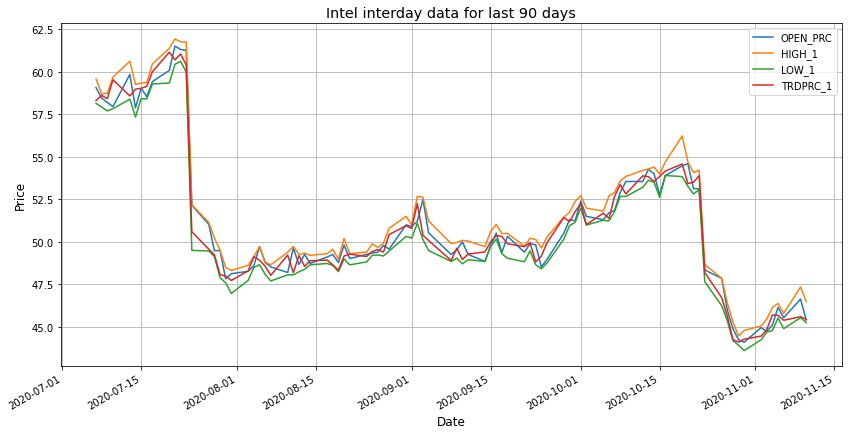

In [14]:
# Plotting a Graph for Intel

columns = ['OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']

intel_df_pricing.set_index('Date',drop=True,inplace=True)
intel_figure = plt.figure()

plt.xlabel('Date', fontsize='large')
plt.ylabel('Price', fontsize='large')


# Create graph title from Company and RIC names dynamically.
plt.ticklabel_format(style = 'plain')
plt.title('Intel interday data for last 90 days', color='black',fontsize='x-large')
ax = intel_figure.gca()

intel_df_pricing.plot(kind='line', ax = intel_figure.gca(),y=columns,figsize=(14,7) , grid = True)
plt.show()

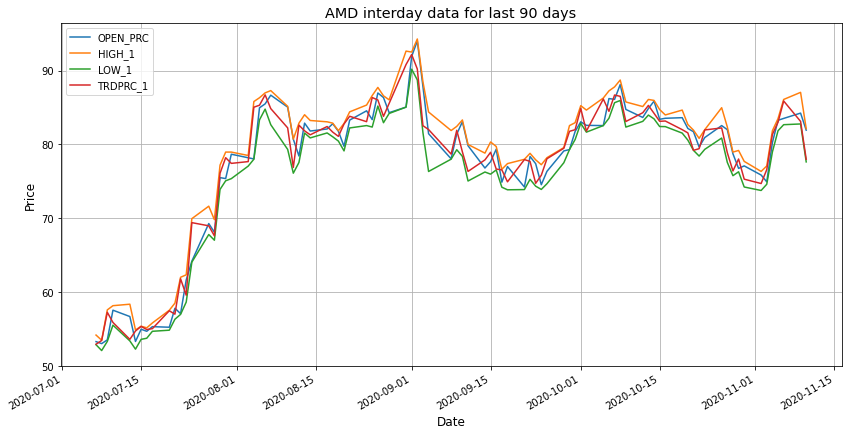

In [15]:
# Plotting a Graph for AMD

columns = ['OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']

amd_df_pricing.set_index('Date',drop=True,inplace=True)
amd_figure = plt.figure()

plt.xlabel('Date', fontsize='large')
plt.ylabel('Price', fontsize='large')


# Create graph title from Company and RIC names dynamically.
plt.ticklabel_format(style = 'plain')
plt.title('AMD interday data for last 90 days', color='black',fontsize='x-large')
ax = amd_figure.gca()

amd_df_pricing.plot(kind='line', ax = amd_figure.gca(),y=columns,figsize=(14,7), grid = True )
plt.show()

Now we got the charts and figure objects ready for the Pricing Sheet report. Next, we will create the Volume comparision chart for the Intel vs AMD Volume comarision Sheet.

### Intel vs AMD Volume Comparision

The next chart is blck trading volume comparision which is *BLKVOLUM* data field. This chart contains Intel and AMD data in the same figure.

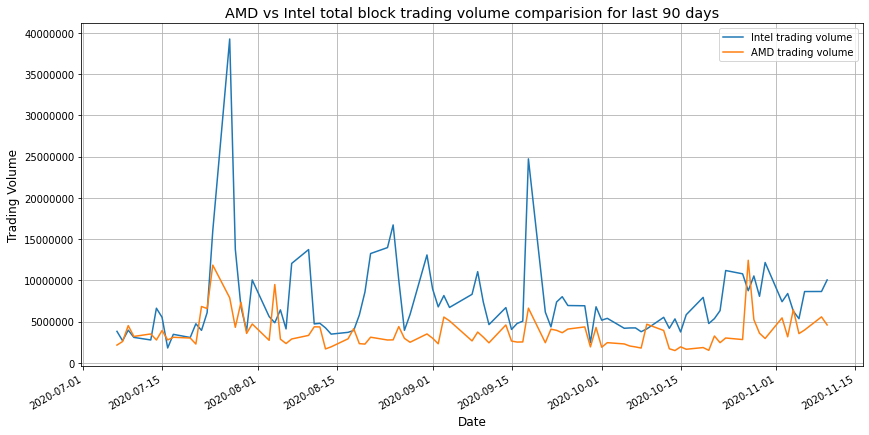

In [16]:
columns = ['BLKVOLUM']

# Intel
#intel_df_pricing.set_index('Date',drop=True,inplace=True)
intel_amd_volume_figure = plt.figure()

plt.xlabel('Date', fontsize='large')
plt.ylabel('Trading Volume', fontsize='large')

# Create graph title from Company and RIC names dynamically.
plt.ticklabel_format(style = 'plain')
plt.title('AMD vs Intel total block trading volume comparision for last 90 days', color='black',fontsize='x-large')
ax = intel_amd_volume_figure.gca()

intel_df_pricing.plot(kind='line', ax = intel_amd_volume_figure.gca(),y=columns,figsize=(14,7) , label=['Intel trading volume'],grid = True)

# AMD
#amd_df_pricing.set_index('Date',drop=True,inplace=True)
amd_df_pricing.plot(kind='line', ax = ax ,y=columns,figsize=(14,7), label=['AMD trading volume'],grid = True)

#fig_concat = plt.figure()

plt.show()

## Generate Report with xlwings PRO

Now all data (DataFrame and Charts) is ready. We have demonstrated the [report-api](https://docs.xlwings.org/en/stable/api.html#reports-api) and with Report package ```create_report()``` function in the [part-1 notebook](./rdp_xlwingsce_notebook.ipynb) as following example.

```
wb = create_report(
    'rdp_report_template.xlsx', 
    'rdp_report_pro.xlsx', 
    historical_title=historical_title, 
    df_historical=df_historical.head(10), 
    graph= fig
)
```

The above code is ok for a small data. This part-2 notebook will show more features that developers can work with the ```create_report()``` function for supporting various requirements and template variables.

Firstly, lets define static texts and template/report file location.

In [17]:
# Define Static texts and template/report file location.
intel_price_title='Intel Hitorical Data'
amd_price_title = 'AMD Historical Data'

template_file = 'part2_rdp_report_template.xlsx' 
report_file = 'part2_rdp_intel_vs_amd.xlsx' 

Next, we create the Python [Dictionary](https://docs.python.org/3.7/tutorial/datastructures.html#dictionaries) object to collect all data for template variables. Please note that the Dictionary keys must have the same names as template variables.

When using Excel tables, DataFrame indices are excluded by default. We would like to include them in the report, so we reset the index before providing the DataFrame to the ```create_report``` function with [df.reset_index()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) function.

In [26]:
# Create Dictionary to collect all report data
data = dict(
    intel_price_title=intel_price_title,
    intel_price_df = intel_df_pricing.head(15).reset_index(),
    intel_graph = intel_figure,
    amd_price_title = amd_price_title,
    amd_price_df = amd_df_pricing.head(15).reset_index(),
    amd_graph = amd_figure,
    intel_amd_volume_graph = intel_amd_volume_figure,
)

Then we call the create_report function.

In [27]:
wb = create_report(
    template_file, 
    report_file, 
    **data
)

2020-11-11 15:23:54,847 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:26:29,013 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:29:03,469 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:31:38,149 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:34:12,134 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:36:46,454 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:39:20,636 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:41:54,545 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11 15:44:28,812 - Session session.platform - Thread 18036 | Thread-6
[Error 400 - invalid_grant] None
2020-11-11

The above ```create_report()``` function generates *part2_rdp_intel_vs_amd.xlsx* Excel report file with format/style defined in part2_rdp_report_template.xlsx and data that we pass to the function. With default parameter, the part2_rdp_intel_vs_amd.xlsx file will be open automatically.

![Figure-6](images/xlwingspro/xlwings_pro_report_1.png "xlwings rpo report Intel vs AMD Daily Price Sheet") 


![Figure-7](images/xlwingspro/xlwings_pro_report_2.png "xlwings rpo report Intel vs AMD Volume Sheet") 

You can control the Excel instance by passing in an xlwings App instance. For example, to run the report in a separate and hidden instance of Excel. This is a useful feature if you aims to create the application that run as a background service to generate report monthly or weekly based on the business requirements.

In [42]:
app = xw.App(visible=False)

wb = create_report(
    template_file, 
    'part_2_montly_report.xlsx', 
    app = app,
    **data
)
app.quit()  # Close the wb and quit the Excel instance

Now the *part_2_montly_report.xlsx* Excel report file is created in the background.

## Close RDP Session

In [41]:
# -- Close Session, just calls close_session() function

rdp.close_session()

print(session.get_open_state())

State.Closed


## Embedded Code

xlwings PRO also allows you to store your Python code directly in Excel so you don’t have to distribute separate Python files. This feature lets business users can consume RDP content with the macro-enabled Excel file (*xlsm* file) directly without any Python file required (the [Python](https://www.python.org/downloads/) or [Anaconda](https://www.anaconda.com/distribution/)/ [MiniConda](https://docs.conda.io/en/latest/miniconda.html)  is still required).

Developers can implement the Python application to consume RDP data, then run xlwings ```xlwings code embed``` command in the console to import all Python files from the current directory and paste them into sheets with the same name of the currently active Excel workbook. 

The Python console application is more suitable to demonstrate this feature than via this Jupyter notebook. Please refer to the following RDP - IPA Bond examples file in *python_embedded* folder of this xlwings RDP project:
- rdp_ipa_bond.py: Python application source code.
- rdp_ipa_bond.xlsm: Excel file with embedded code from rdp_ipa_bond.py file.
- README.md: Embedded Code example readme file.

The Python Embedded example shows how to consume bond analytics data to the macro-enabled Excel file via RDP Libraries Financial Contracts API (```rdp.get_bond_analytics()``` function).

Example of Excel file which has the separated data and embedded Python Sheets are following.

![Figure-7](images/xlwingspro/xlwings_pro_embeded_1.png "xlwings rpd IPA data Sheet") 

![Figure-7](images/xlwingspro/xlwings_pro_embeded_2.png "xlwings rpd IPA embedded Python Sheet") 

Once you have setup [xlwings VBA Add-in](https://docs.xlwings.org/en/stable/addin.html), [xlwing RunPython](https://docs.xlwings.org/en/stable/vba.html) and [Embedded Code](https://docs.xlwings.org/en/stable/deployment.html#embedded-code) features; you can run the embedded Python Sheet to get and display IPA Data in data Sheet.

![Figure-7](images/xlwingspro/xlwings_pro_embeded_3.png "xlwings rpo IPA result") 


## Conclusion and Next Step

The xlwings CE library lets Python developers integrate data with Excel in a simple way. The library is suitable for a wide range of developers from casual coders, data scientists, professional traders to seasoned programmers, and allows them to work on data analysis and generate reports based on their skill. 

The next part will cover and show how powerful xlwings PRO is when comparing to CE library. Python developers' life will be easier with xlwings PRO.

In the same time, the [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-libraries) let developers rapid access Refinitiv Platform content with a few line of code that easy to understand and maintenance. Developers can focus on implement the business logic or analysis data without worry about the connection, authentication detail with the Refinitiv Platforms.

The integration between Refinitiv APIs and xlwings is not limited to only RDP Libraries. Any [Refinitiv API](https://developers.refinitiv.com/en/api-catalog?i=1;q1=page-type%3Aapi;q2=devportal%3Alanguages~2Fpython;sort=title;sp_c=12;sp_cs=UTF-8;sp_k=devportal-prod;view=xml;x1=w-page-type-id;x2=api-language) that supports Python such as [Eikon Data API](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api) ([Eikon Data API-xlwings article](https://developers.refinitiv.com/en/article-catalog/article/financial-reporting-with-eikon-and-excel)), or [RKD API](https://developers.refinitiv.com/en/api-catalog/refinitiv-knowledge-direct/refinitiv-knowledge-direct-api-rkd-api) can work with xlwings using the same concept and code logic as this RDP Library notebook example.

## References

You can find more details regarding the Refinitiv Data Platform Libraries, xlwings and related technologies for this notebook from the following resources:
* [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) web site.
* [xlwings web site](https://www.xlwings.org/).
* [Financial Reporting with Eikon, xlwings and Excel](https://developers.refinitiv.com/en/article-catalog/article/financial-reporting-with-eikon-and-excel).
* [xlwings API Reference](https://docs.xlwings.org/en/stable/api.html).
* [xlwings Document page](https://docs.xlwings.org/en/stable/).
* [xlwings PRO Report page](https://www.xlwings.org/reporting).
* [RDP Libraries Quick Start Guide page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start).
* [RDP Libraries Tutorial page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/tutorials).
* [Discover our Refinitiv Data Platform Library (part 1)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-1).
* [Discover our Refinitiv Data Platform Library (part 2)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-2).

For any questions related to this article or Refinitiv Data Platform Libraries, please use the Developers Community [Q&A Forum](https://community.developers.refinitiv.com/spaces/321/refinitiv-data-platform-libraries.html).